In [1]:
import os
os.getcwd()
os.chdir("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad")

In [32]:
from ensemble.model.ensemble import classifiers
from AnoGAN.model.AnoGAN import AnoGAN
from outlier_exposure.cae import *
from GOAD import classifier as clf
import cae
from fastprogress import master_bar, progress_bar
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchmetrics.functional.classification import binary_auroc, binary_accuracy


import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd

In [177]:
from torchvision.datasets import CIFAR10

label = 3
test_dataset = CIFAR10(root='cifar10-data/', train=False, transform=ToTensor())

test_dataset.targets = (torch.Tensor(test_dataset.targets) == label).type(torch.float)

test_dataset = torch.utils.data.Subset(test_dataset, range(2500))
batch_size = 250

test_loader = DataLoader(test_dataset, batch_size, num_workers=2)

In [178]:
classifier = classifiers()

In [179]:
import os
import torch
from fastprogress import master_bar, progress_bar

os.getcwd()
os.chdir("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad")

from ensemble.model.ensemble import classifiers
classifier = classifiers()

simple_preds = torch.load("preds.pt")
y = torch.load("y.pt")
simple_preds = simple_preds.to(torch.float32)

from torchmetrics.functional.classification import binary_auroc, binary_accuracy
import torch.nn as nn
optim = torch.optim.Adam(classifier.parameters(), lr = .03, betas=(.01, 0.999))
loss = torch.nn.BCELoss()
aaa = []
weights = []
bias = []
mb = progress_bar(range(5000))
for i in mb:
    out = classifier.Linear(simple_preds.T)
    out = torch.sigmoid(out).T
    bce_loss = loss(out, y) + loss(out[y == 1], y[y == 1])  
    # print()

    
    # print(bce_loss)
    # print("{} AUROC:".format(i), binary_accuracy(out.T, y))
    # mb.comment = binary_auroc(out, y)
    aaa.append(binary_auroc(out, y))
    weights.append(classifier.classifier.weight)
    bias.append(classifier.classifier.bias)
    
    if binary_auroc(out, y) > .9:
        break
    bce_loss.backward()
    optim.step()
    
classifier.classifier.weight.data = weights[aaa.index(max(aaa))].view(1,3)
classifier.classifier.bias.data = bias[aaa.index(max(aaa))]

out = classifier.Linear(simple_preds.T)
out = torch.sigmoid(out).T

binary_auroc(out, y)

tensor(0.8648)

In [180]:
weights[aaa.index(max(aaa))].view(1,3)

tensor([[ 6.7372, 14.8481,  2.3545]], grad_fn=<ViewBackward0>)

In [181]:
anogan = torch.load("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\AnoGAN\\AnoGAN_model_{}.pt".format(label))

GOAD_preds = torch.load("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\GOAD_scores_class_3.pt")
# GOAD = torch.load("C:\\Users\\galli\\Documents\\GitHub\\cs7643_final_project\\ensemble_ad\\GOAD_trained_model_class_1.pt")
CAE_preds = torch.Tensor(np.loadtxt("new_cae_anomaly_scores.txt"))

In [182]:
new_CAE = ((CAE_preds - CAE_preds.min()) / (CAE_preds.max() - CAE_preds.min()))

In [135]:
batch_y

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]])

In [37]:
anogan = anogan.cpu()
batch_acc = torch.empty(len(test_loader), 1)
batch_auroc = torch.empty(len(test_loader), 1)
batch_preds = torch.empty(len(test_loader), 1, batch_size)
batch_y = torch.empty(len(test_loader), batch_size)
for j, (batch, y) in enumerate(test_loader):
    print("Batch", j)
    pred, auroc, acc, g, d, fake, real = anogan.predict((batch, y))
    # for i in range(250):
    #     batch_preds[j, 1, i] = CAE.predict(batch[i].cuda())
    batch_acc[j, 0] = acc
    batch_auroc[j, 0] = auroc
    batch_preds[j, 0, :] = pred
    batch_y[j, :] = y

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9


In [254]:
batch_acc.mean(dim = 0)
batch_auroc.mean(dim = 0)
all_preds = batch_preds.view(1, -1)
all_y = batch_y.view(1, -1)
torch.save(all_y, "y.pt")

In [255]:
AnoGAN_acc = float(binary_accuracy(batch_preds[:,0,:], batch_y))
AnoGAN_focal = float(binary_accuracy(batch_preds[:,0,:][batch_y == 1], batch_y[batch_y == 1]))
AnoGAN_auroc = float(binary_auroc(batch_preds[:,0,:], batch_y))

GOAD_acc = float(binary_accuracy(1-GOAD_preds[:2500].view(10,250), batch_y))
GOAD_focal = float(binary_accuracy(1-GOAD_preds[:2500].view(10,250)[batch_y == 1], batch_y[batch_y == 1]))
GOAD_auroc = float(binary_auroc(1- GOAD_preds[:2500].view(10,250), batch_y))

CAE_acc = float(binary_accuracy(1- new_CAE[:2500].view(10,250), batch_y))
CAE_focal = float(binary_accuracy(1- new_CAE[:2500].view(10,250)[batch_y == 1], batch_y[batch_y == 1]))
CAE_auroc = float(binary_auroc(1- new_CAE[:2500].view(10,250), batch_y))

In [256]:
simple_preds = torch.cat((all_preds, 1-GOAD_preds[:2500].view(1,2500), 1- new_CAE[:2500].view(1,2500)))
torch.save(simple_preds, "preds.pt")

In [257]:
avg_acc = float(binary_accuracy(simple_preds.mean(dim = 0), all_y[0, :]))
avg_focal = float(binary_accuracy(simple_preds.mean(dim = 0)[all_y.squeeze(0) == 1], all_y.squeeze(0)[all_y.squeeze(0) == 1]))
avg_auroc = float(binary_auroc(simple_preds.mean(dim = 0), all_y[0, :]))

In [258]:
AnoGAN_auroc - voting_auroc

0.05554908514022827

In [259]:
Voting = classifier.VotingClassifier(simple_preds)
voting_acc = float(binary_accuracy(Voting, all_y[0, :]))
voting_focal = float(binary_accuracy(Voting[all_y.squeeze(0) == 1], all_y.squeeze(0)[all_y.squeeze(0) == 1]))
voting_auroc = float(binary_auroc(Voting, all_y[0, :]))

In [260]:
float(binary_auroc(t.squeeze(0), all_y[0, :]))



AttributeError: 'float' object has no attribute 'squeeze'

In [261]:
owa_acc = float(binary_accuracy(out.squeeze(0), all_y[0, :]))
owa_focal = float(binary_accuracy(out.squeeze(0)[all_y.squeeze(0) == 1], all_y.squeeze(0)[all_y.squeeze(0) == 1]))
owa_auroc = float(binary_auroc(out.squeeze(0), all_y[0, :]))

In [272]:
ano_false_pos, ano_true_pos, ano_thresholds = metrics.roc_curve(all_y[0, :].detach().numpy(), all_preds[0, :].detach().numpy(), pos_label = 1)

goad_false_pos, goad_true_pos, goad_thresholds = metrics.roc_curve(all_y[0, :].detach().numpy(), (1-GOAD_preds[:2500]).detach().numpy(), pos_label = 1)

cae_false_pos, cae_true_pos, cae_thresholds = metrics.roc_curve(all_y[0, :].detach().numpy(), (1-new_CAE[:2500]).detach().numpy(), pos_label = 1)

avg_false_pos, avg_true_pos, avg_thresholds = metrics.roc_curve(all_y[0, :].detach().numpy(), simple_preds.mean(dim = 0).detach().numpy(), pos_label = 1)

voting_false_pos, voting_true_pos, voting_thresholds = metrics.roc_curve(all_y[0, :].detach().numpy(), Voting.detach().numpy(), pos_label = 1)

owa_false_pos, owa_true_pos, owa_thresholds = metrics.roc_curve(all_y[0, :].detach().numpy(), out.squeeze(0).detach().numpy(), pos_label = 1)

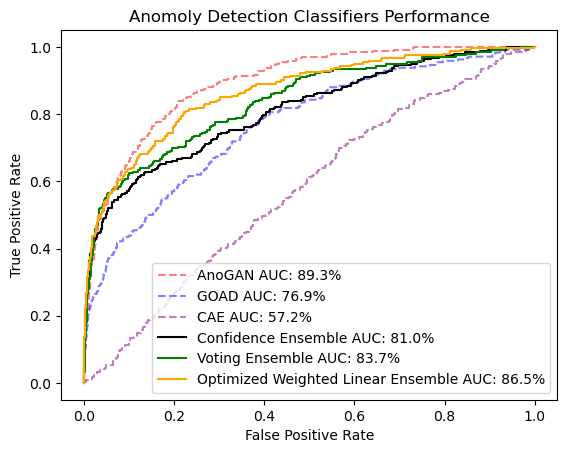

In [273]:
fig = plt.figure()

plt.plot(ano_false_pos, ano_true_pos, alpha = .5, label='AnoGAN AUC: {:.1f}%'.format(round(AnoGAN_auroc*100,1)), color = "r", linestyle = "--")
plt.plot(goad_false_pos, goad_true_pos, alpha = .5, label='GOAD AUC: {:.1f}%'.format(round(GOAD_auroc*100,1)), color = "b", linestyle = "--")
plt.plot(cae_false_pos, cae_true_pos, alpha = .5, label='CAE AUC: {:.1f}%'.format(round(CAE_auroc*100,1)), color = "purple", linestyle = "--")
plt.plot(avg_false_pos, avg_true_pos, label='Confidence Ensemble AUC: {:.1f}%'.format(round(avg_auroc*100,1)), color = "black")
plt.plot(voting_false_pos, voting_true_pos, label='Voting Ensemble AUC: {:.1f}%'.format(round(voting_auroc*100,1)), color = "green")
plt.plot(owa_false_pos, owa_true_pos, label='Optimized Weighted Linear Ensemble AUC: {:.1f}%'.format(round(owa_auroc*100,1)), color = "orange")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Anomoly Detection Classifiers Performance")
plt.legend()

In [274]:
df = pd.DataFrame(index = ["AUROC", "Total Accuracy", "Focal Accuracy"])

cellVals = [AnoGAN_auroc, AnoGAN_acc, AnoGAN_focal]
df["AnoGAN"] = cellVals
cellVals = [GOAD_auroc, GOAD_acc, GOAD_focal]
df["GOAD"] = cellVals
cellVals = [CAE_auroc, CAE_acc, CAE_focal]
df["CAE"] = cellVals
cellVals = [avg_auroc, avg_acc, avg_focal]
df["Average Classifier"] = cellVals
cellVals = [voting_auroc, voting_acc, voting_focal]
df["Voting Classifier"] = cellVals
cellVals = [owa_auroc, owa_acc, owa_focal]
df["OWL Classifier"] = cellVals

df.values

array([[0.89272124, 0.76908457, 0.57185835, 0.81049752, 0.83717215,
        0.86475444],
       [0.91839999, 0.912     , 0.3188    , 0.92519999, 0.92159998,
        0.73799998],
       [0.26859504, 0.23140496, 0.8429752 , 0.40909091, 0.33471075,
        0.83057851]])

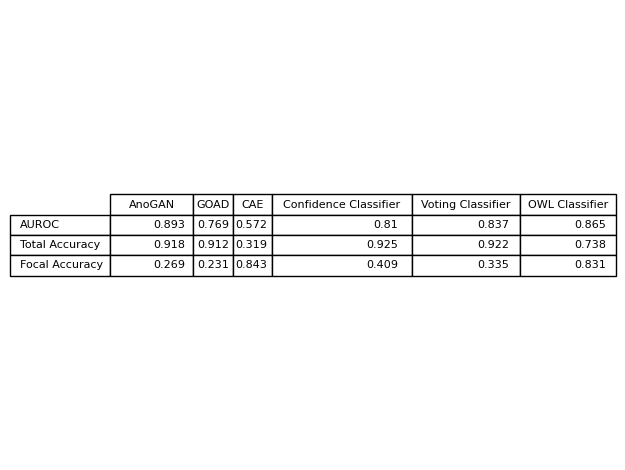

In [275]:


fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

tbl =ax.table(cellText = df.values.round(3),
          rowLabels = ["AUROC", "Total Accuracy", "Focal Accuracy"],
          colLabels = ["AnoGAN", "GOAD", "CAE", "Confidence Classifier", "Voting Classifier", "OWL Classifier"],
          loc = "center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(5)
tbl.auto_set_column_width(4)
tbl.auto_set_column_width(3)
tbl.auto_set_column_width(2)
tbl.auto_set_column_width(1)
fig.tight_layout()
plt.show()

In [284]:
votes = torch.where(simple_preds > 0.5, 1,0)
votes



tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 1, 0]])

In [300]:
most_common = torch.mode(votes == all_y, dim = 0).values

most_common[all_y.squeeze(0) == 1].sum()

tensor(81)

In [304]:
most_common[all_y.squeeze(0) == 1].sum() / all_y.squeeze(0)[all_y.squeeze(0) == 1].sum()

tensor(0.3347)

In [235]:
classifier.classifier.weight.data.fill_(.3333)

tensor([[0.3333, 0.3333, 0.3333]])

In [245]:
aaa.index(max(aaa))

1825

In [246]:
max(aaa)

tensor(0.8945)

In [196]:
classifier.classifier.weight

Parameter containing:
tensor([[ 6.7372, 14.8481,  2.3545]], requires_grad=True)

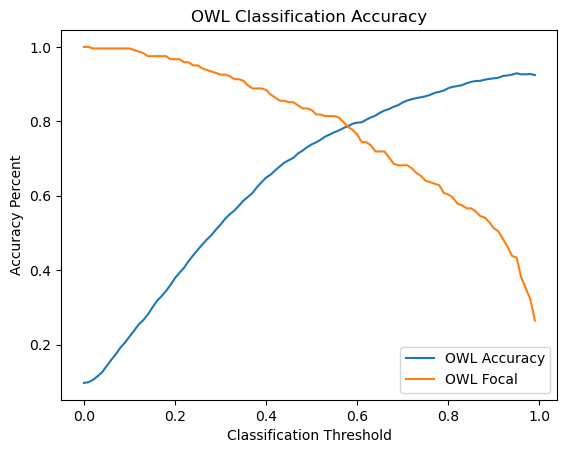

In [250]:
owl_a = []
owl_f = []

for i in np.arange(0,1,.01):
    owl_a.append(binary_accuracy(out, all_y, threshold = i))
    owl_f.append(binary_accuracy(out[all_y == 1], all_y[all_y == 1], threshold = i))
# print(binary_auroc(torch.where(out > t,
#                                (out - t)/(1 - t)* (1 - .5)+.5,
#                                (out - 0)/(t-0)* (.5 - 0)+0), all_y))
plt.plot(np.arange(0,1,.01), owl_a, label = "OWL Accuracy")
plt.plot(np.arange(0,1,.01), owl_f, label = "OWL Focal")
plt.xlabel("Classification Threshold")
plt.ylabel("Accuracy Percent")
plt.title("OWL Classification Accuracy")
plt.legend()


In [249]:
bias[aaa.index(max(aaa))]

Parameter containing:
tensor([-2.9498], requires_grad=True)

In [250]:
out = classifier.Linear(simple_preds.T)
out = torch.sigmoid(out).T

In [372]:
binary_accuracy(simple_preds[0], all_y[0], threshold = .37)
binary_accuracy(simple_preds[0, all_y == 1], all_y[all_y == 1], threshold = .9)

IndexError: too many indices for tensor of dimension 2

In [352]:
all_y.squeeze(0)[all_y.squeeze(0) == 1].sum()

tensor(242.)

In [353]:
(torch.where(simple_preds[:, all_y.squeeze(0) == 1] > .5, 1,0) == all_y.squeeze(0)[all_y.squeeze(0) == 1]).max(dim = 0).values.sum() / 242

tensor(0.9174)